In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# (1) EDA (Exploratory Data Analysis)

Let's first inspect the dataset with `.head()` and `.tail()` to retrieve the first 5 and the last 5 rows of the dataset. We see that it consists of a table of only 2 columns : `Month` and `#Passengers`. The first column, `Month`, actually contains string values consisting of a concatenation of year and month in the format `yyyy-mm`. The second column contains the number of passengers, in integer form. We can check that there is no missing data with `.isna().sum()`. To confirm the types of the values in each column, we can access the attribute `.dtypes`. Finally, we can get a first review of the quantitative columns, in this case only `#Passengers`, with the method `.describe()`.

In [3]:
path = 'data/AirPassengers.csv'
df = pd.read_csv(path)
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [5]:
df.isna().sum()

Month          0
#Passengers    0
dtype: int64

In [6]:
df.dtypes

Month          object
#Passengers     int64
dtype: object

In [7]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


We can even make a quick plot of the histogram of `#Passengers` to have an image of its distribution. We observe that it doesn't look like a normal distribution, and that it is rather irregular.

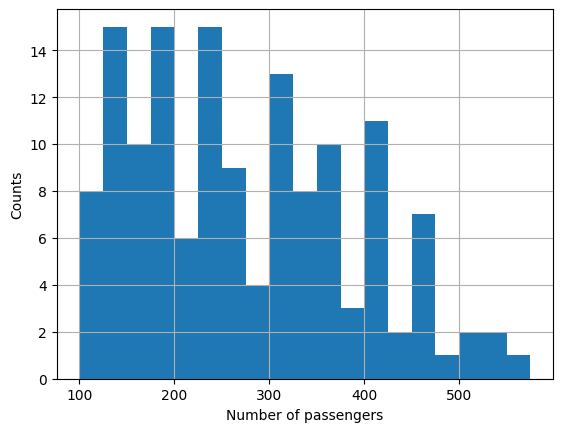

In [8]:
plt.hist(df['#Passengers'], bins=[100 + 25*i for i in range(20)])
plt.xlabel('Number of passengers')
plt.ylabel('Counts')
plt.grid()
plt.show()

We transform the `Month` column to datetime to facilitate the work for the following time-series analysis. Indeed, when working with dates and times, it's preferable that the Pandas dataframe is aware that a string column contains this type of values.

We make this new column `Date` the index of the table. This also ensures that there are no duplicates.

In [9]:
df['Date'] = pd.to_datetime(df['Month'], format='%Y-%m')
df = df.drop(columns=['Month'])
df = df.set_index('Date')
df.head()

,#Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


By plotting the number of passengers vs time, we observe this nice oscillating function with an increasing trend. Each year, the mean number of passengers is higher, and the seasonal effects are more important.

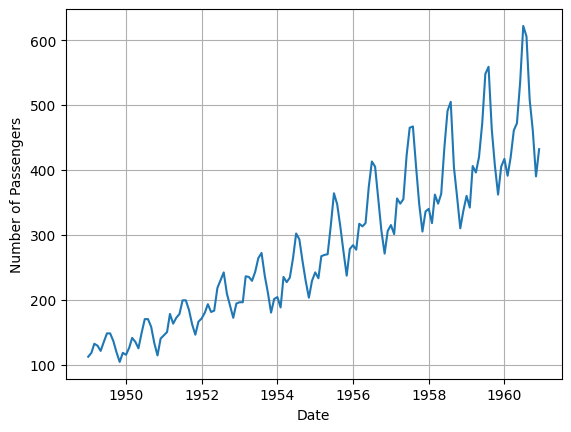

In [10]:
sns.lineplot(df, legend=False)
plt.ylabel('Number of Passengers')
plt.grid()
plt.show()

We can plot a zoomed in view of the last 2 years to determine that the seasonal increase of the number of passengers happens from june to september each year, with the peak at either july or august.

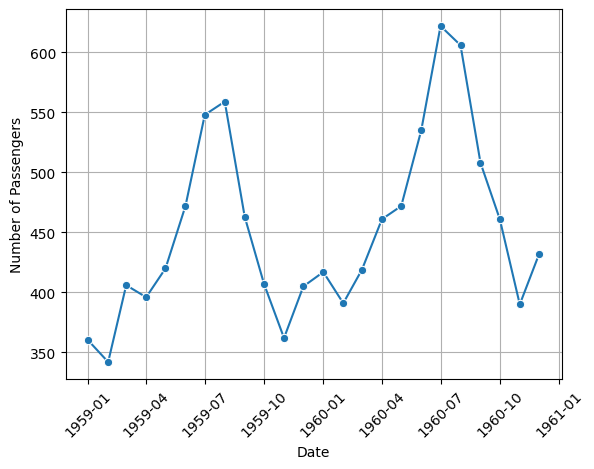

In [11]:
sns.lineplot(df[-24:], markers='o', legend=False)
plt.ylabel('Number of Passengers')
plt.xticks(rotation=45)
plt.grid()
plt.show()

As the seasonal effects are occurring in a frequency of one year, apparently, we can start to work with the rolling averages, that is, we group each set of 12 consecutive rows (as each row represents a month) and we compute the average of those values. So, we have a value for 1949 from january to december, a value for 1949 from february to december and 1950 january, etc. Alternatively, we can think that for each month from 1949 december to 1960 december, we have the average of the number of passengers of the last 12 months.

Indeed, if we plot this rolling averages, we see that the corresponding line (red) starts at 1949 december.

In [12]:
rolling_mean = df.rolling(12).mean()
rolling_std = df.rolling(12).std()
top = rolling_mean + rolling_std
bottom = rolling_mean - rolling_std

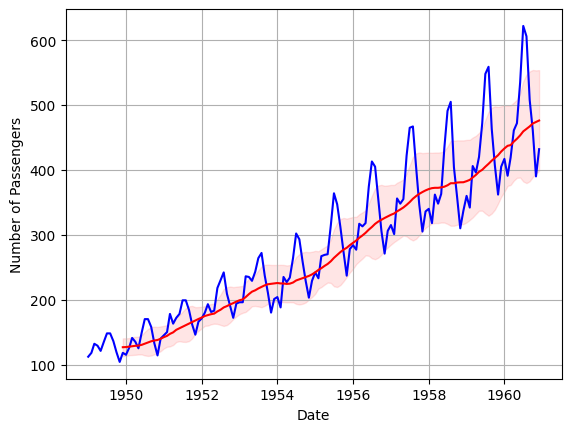

In [13]:
sns.lineplot(df, palette=['b'], legend=False)
sns.lineplot(rolling_mean, palette=['r'], legend=False)
plt.fill_between(bottom.index, bottom['#Passengers'], top['#Passengers'], color='r', alpha=.1)
plt.ylabel('Number of Passengers')
plt.grid()
plt.show()

We have also plotted the area around the rolling averages of 65% confidence. Indeed, this area corresponds to the intervals $[\mu - \sigma, \mu + \sigma]$. It's interesting to see that each year, the values of july and august fall out of this interval. They are, in a sense, outliers.

# (2) Statistical Analysis

We can use some functions of statsmodels to check some properties of the values. For instance, we can start with the augmented Dickey-Fuller test to study the stationarity of the data. We expect negative results from this test, as we have observed that the data has a positive trend, and that the rolling averages grow every month.

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [15]:
adft = adfuller(df, autolag='AIC')
print(f'Test statistic = {adft[0]:.2f}')
print(f'p-value = {adft[1]:.2f}')

Test statistic = 0.82
p-value = 0.99


With such a high probability of the null hypothesis being true, we cannot reject it. The data is, as we expected, non-stationary.

## (2.1) Autocorrelation

The `statsmodels` package includes functions to plot autocorrelation and partial autocorrelation charts. Below we observe that the data might be explained with an autoregressive (AR) model, as the autocorrelation values slowly decay in the autocorrelation plot.

However, the high value of autocorrelation at lag 1 indicates that the data is non-stationary. Indeed, we have observed above that the data has a positive trend.

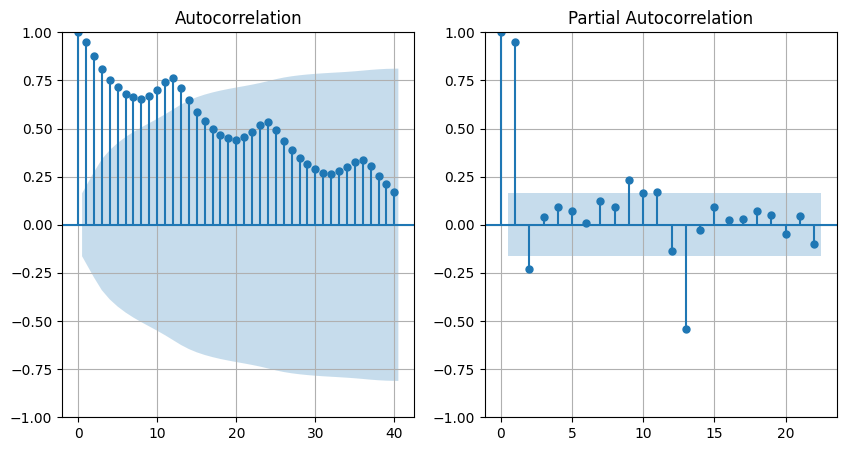

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plot_acf(df, ax=axs[0], lags=40)
axs[0].grid()

plot_pacf(df, ax=axs[1])
axs[1].grid()

plt.show()

To fix this, we can just study the first difference of the data, that is, for each month, we consider the difference in number of passengers with respect to the previous month.

Below we observe that this new set of data (orange) differs from the original (blue) in that it has no positive trend. We achieved a null mean, we are close to stationary !

But not yet ! There are still some seasonal effects present. Indeed, positive peaks in the original (blue) data correspond to positive peaks in the new line (orange). We can get rid of these by differencing again, this time w.r.t. the 12th period. Now, with this stationary line (green) we can continue our analysis.

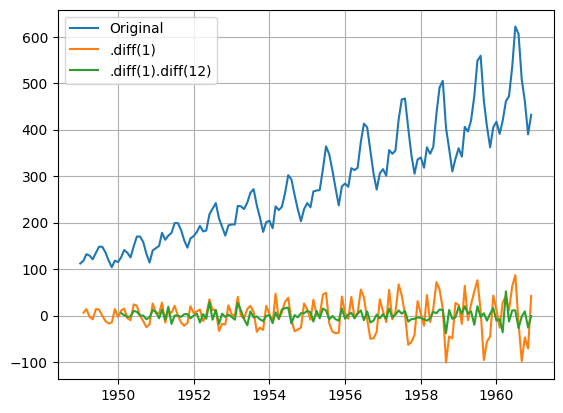

In [17]:
plt.plot(df, label='Original')
plt.plot(df.diff(1), label='.diff(1)')
plt.plot(df.diff(1).diff(12), label='.diff(1).diff(12)')
plt.grid()
plt.legend()
plt.show()

To start, we can repeat the augmented Dickey-Fuller test and see that now the data is, indeed, stationary :

In [18]:
df_stationary = df.diff(1).diff(12).dropna()

adft = adfuller(df_stationary, autolag='AIC')
print(f'Test statistic = {adft[0]:.2f}')
print(f'p-value = {adft[1]:.10f}')

Test statistic = -15.60
p-value = 0.0000000000


If we replot the autocorrelation and partial autocorrelation charts, we now see that only the 1st lag has some relevance for an autorregressive model.

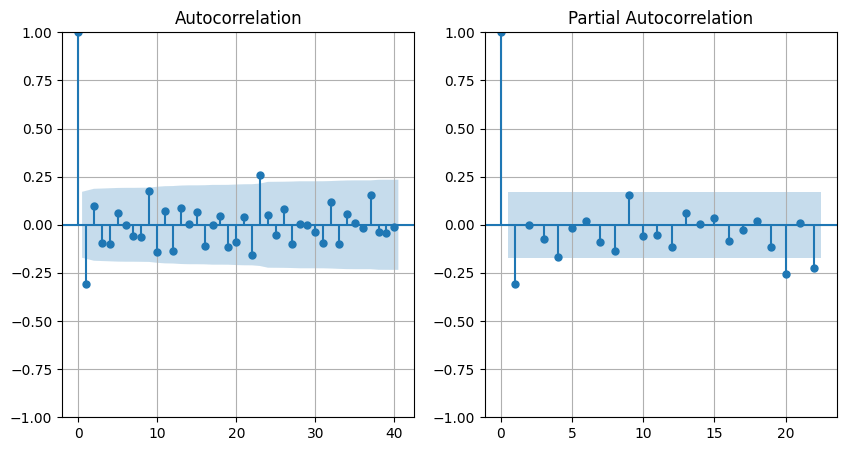

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plot_acf(df_stationary, ax=axs[0], lags=40)
axs[0].grid()

plot_pacf(df_stationary, ax=axs[1])
axs[1].grid()

plt.show()

## (2.2) Naive model

Another function of statsmodels is `seasonal_decompose`, that identifies the trend and the seasonal effect in the data.

The last plot shows the residuals, that is, the errors of this seasonal model. We see how the errors are low in the first years, but they can increase up to 50 passengers in the last rows of the dataset. This means that the seasonal effects are not so regular every year, and a simple model like this one might not be fit to extrapolate to new years.

In the next notebook, we will work with a naive model made out of this decomposition.

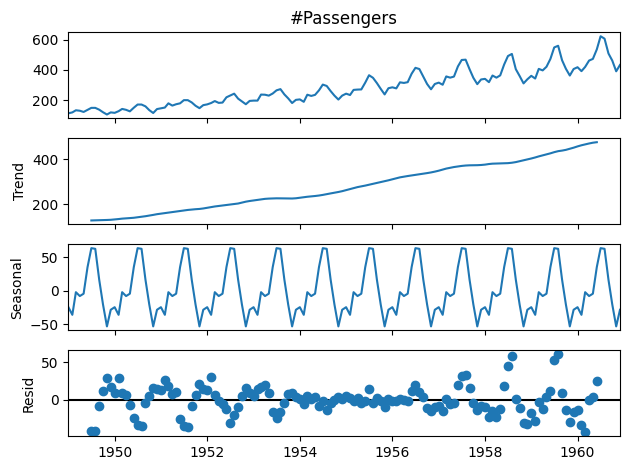

In [20]:
decompose = seasonal_decompose(df['#Passengers'], model='additive', period=12)
decompose.plot()
plt.show()